In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'accurate.xlsx', 'comments.txt', 'dot_result.csv', 'dot_result_new.csv', 'feature_importance.png', 'rmse1.csv', 'test.csv', 'test_predict.png']


In [2]:
rcParams['figure.figsize'] = 16,4

## 读取数据

In [3]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [4]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)
data = dot_data.copy()
data.head()

,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [5]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [6]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


## 数据预处理

In [7]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,嘉定城区点部,2017-12-01,20
2017-12-01,荔湾芳村二级装卸组,2017-12-01,1
2017-12-01,无锡旺庄点部,2017-12-01,58
2017-12-01,宝安机场分拨一区包车组,2017-12-01,2


In [8]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
len(useful_dot_name)

338

In [9]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = data.loc[data['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2018-12-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i + 1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 390:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [10]:
dot_prep = dot_preprocessing[['dot', 'dot_id', 'order_date', 'order_num']]
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133848 entries, 0 to 133847
Data columns (total 4 columns):
dot           133848 non-null object
dot_id        133848 non-null int64
order_date    133848 non-null datetime64[ns]
order_num     133848 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.1+ MB


## 创建特征

In [11]:
def create_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
#     dot_prep_1['season'] = 1
#     dot_prep_1.loc[dot_prep_1['month'].isin([1,2,3]), ['season']] = 1
#     dot_prep_1.loc[dot_prep_1['month'].isin([4,5,6]), ['season']] = 2
#     dot_prep_1.loc[dot_prep_1['month'].isin([7,8,9]), ['season']] = 3
#     dot_prep_1.loc[dot_prep_1['month'].isin([10,11,12]), ['season']] = 4
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    
    # lagging
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    
    # rolling
    dot_prep_3 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.columns = ['rolling3', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = dot_ts.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [12]:
dot_prep_feature = create_feature(dot_prep)

In [13]:
dot_train = dot_prep_feature[: -(30 * 338)]
dot_test = dot_prep_feature[-(30 * 338) :]   # 每个点部留一个月数据做测试

In [14]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

## 评估函数

In [15]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [16]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,                   # [0,1]， 默认0.3
        "n_estimators": 3300,
        "max_depth": 5,                         # [0,∞]， 默认6
        "min_child_weight": 3,                  # [0,∞]， 默认1
        "gamma": 0.5,                             # [0,∞]， 默认0
        "subsample": 0.9,                       # (0,1]， 默认1
        "colsample_bytree": 0.8,                # (0,1]， 默认1
        "silent": 1,                            # 默认0，输出信息
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    return gbm

def xgb_predict(gbm, dot_train, x_test, y_test, path):
    # 验证
    dot_train['order_date'] = dot_train['order_date'] + pd.DateOffset(days = 1)
    dot_train['lagging7'] = dot_train['lagging6']
    dot_train['lagging6'] = dot_train['lagging5']
    dot_train['lagging5'] = dot_train['lagging4']
    dot_train['lagging4'] = dot_train['lagging3']
    dot_train['lagging3'] = dot_train['lagging2']
    dot_train['lagging2'] = dot_train['lagging1']
    dot_train['lagging1'] = dot_train['order_num']
    
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    for order_date in x_test['order_date'].unique():
        test_X = dot_train[dot_train['order_date'] == order_date]
        y_pre = gbm.predict(test_X.drop(['dot', 'order_date', 'order_num'], axis = 1))
        
        dot_train['lagging7'] = dot_train['lagging6']
        dot_train['lagging6'] = dot_train['lagging5']
        dot_train['lagging5'] = dot_train['lagging4']
        dot_train['lagging4'] = dot_train['lagging3']
        dot_train['lagging3'] = dot_train['lagging2']
        dot_train['lagging2'] = dot_train['lagging1']
        dot_train['lagging1'] = y_pre
        
        dot_train['order_date'] = dot_train['order_date'] + pd.DateOffset(days = 1)
        
        
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : y_pre})
    result['RMSE'] = RMSE(y_test, y_pre)
    result['MAE'] = MAE(y_test, y_pre)
    print("MAE : ", MAE(y_test, y_pre), " RMSE : ", RMSE(y_test, y_pre))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [27]:
gbm = xgboost_model(dot_xtrain, dot_ytrain, dot_xtest, dot_ytest, path)
result = xgb_predict(gbm, x_test, y_test, path)

start :  2019-02-12 17:18:11
end :  2019-02-12 17:24:59
year 	 0.00029687292
month 	 0.007960593
day 	 0.020077407
dayofweek 	 0.04467388
dayofyear 	 0.017955314
weekofyear 	 0.0027268329
weekofsun 	 0.004980868
holidays 	 0.014271892
lagging1 	 0.20088401
lagging2 	 0.18685402
lagging3 	 0.03553679
lagging4 	 0.03338171
lagging5 	 0.03102872
lagging6 	 0.035349872
lagging7 	 0.05371201
rolling3 	 0.24788891
rolling7 	 0.062420283


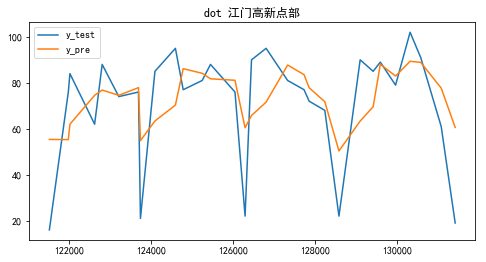

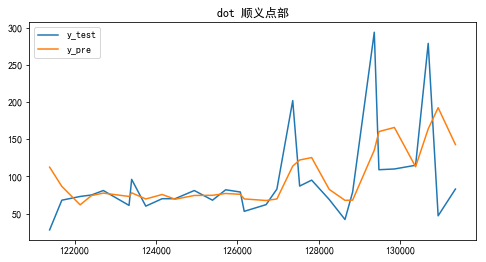

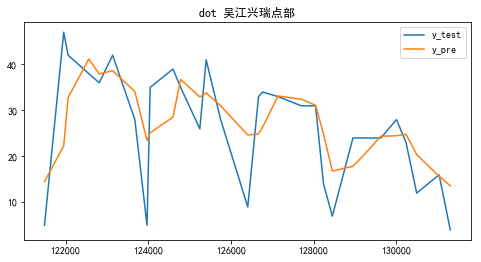

In [31]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 337, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

In [ ]:
# def xgboost_model(x_train, y_train, x_test, y_test, path):
#     params = {
#         "learning_rate": 0.01,                   # [0,1]， 默认0.3
#         "n_estimators": 3300,
#         "max_depth": 5,                         # [0,∞]， 默认6
#         "min_child_weight": 3,                  # [0,∞]， 默认1
#         "gamma": 0.5,                             # [0,∞]， 默认0
#         "subsample": 0.9,                       # (0,1]， 默认1
#         "colsample_bytree": 0.8,                # (0,1]， 默认1
#         "silent": 1,                            # 默认0，输出信息
#         "reg_alpha" : 0.05,
#         "reg_lambda" : 0.05,
#         "seed": 21
#     }
#     print("start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
#     gbm = xgb.XGBRegressor(**params)
#     gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    
#     x_test['lagging7'] = x_test['lagging6']
#     x_test['lagging6'] = x_test['lagging5']
#     x_test['lagging5'] = x_test['lagging4']
#     x_test['lagging4'] = x_test['lagging3']
#     x_test['lagging3'] = x_test['lagging2']
#     x_test['lagging2'] = x_test['lagging1']
#     x_test['lagging1'] = y_test
#     for i in range(30):
#         y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
        
#         x_test['lagging7'] = x_test['lagging6']
#         x_test['lagging6'] = x_test['lagging5']
#         x_test['lagging5'] = x_test['lagging4']
#         x_test['lagging4'] = x_test['lagging3']
#         x_test['lagging3'] = x_test['lagging2']
#         x_test['lagging2'] = x_test['lagging1']
#         x_test['lagging1'] = y_pre
        
# #         x_test['y_pre'] = y_pre
#         x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
#         result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_pre' : y_pre})
#         result.to_csv(path + "dot_result_new.csv", encoding = 'GBK', mode = 'a', index = False)
        
#     print("end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
#     for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
#         print(column, '\t', importance)
#     return result